# Load the data and libraries

In [1]:
# imports
import pandas as pd
import datetime as dt


# data
df = pd.read_csv('./data/clean_data_v2.csv', low_memory=False)
# drop nulls in one target col
# df = df[~df['AvgHourlyLaborCost'].isnull()]
df.head()

,CalendarYear,OfficeName,AccountState,AccountZip,AccountNaicsName,ServiceName,ServiceLineName,IndustryName,JobTaxComplexity,JobName,ChargeHours,ProductionRevActual,Cost,NumAssociatesOnJob,# of Locations,Annual Sales,Assets,Employees,SEC/Publicly Traded
0,2020,"Wausau, WI (30)",WI,54474,Food (Health) Supplement Stores,Accounting assistance - A&A,Audit & Accounting (10),Mfg. Retail Distribution,Not Applicable,Accounting assistance - A&A-2013,0.0,0.0,0.00,1,0.0,5M - 9.9M,Unknown,Unknown,No
1,2020,"Wausau, WI (30)",WI,54474,Food (Health) Supplement Stores,Property Tax,Tax (20),Mfg. Retail Distribution,Not Applicable,Property Tax-260068,0.8,175.5,29.63,4,0.0,5M - 9.9M,Unknown,Unknown,No
2,2021,"Wausau, WI (30)",WI,54474,Food (Health) Supplement Stores,Property Tax,Tax (20),Mfg. Retail Distribution,Not Applicable,Property Tax-260068,0.6,72.0,16.74,2,0.0,5M - 9.9M,Unknown,Unknown,No
3,2020,"Wausau, WI (30)",WI,54474,Food (Health) Supplement Stores,Accounting assistance - A&A,Audit & Accounting (10),Mfg. Retail Distribution,Not Applicable,Special Accounting Project,0.5,100.0,20.69,2,0.0,5M - 9.9M,Unknown,Unknown,No
4,2020,"Wausau, WI (30)",WI,54474,Food (Health) Supplement Stores,Other Consulting-Sales/Use,Tax (20),Mfg. Retail Distribution,Not Applicable,Other Consulting-Sales/Use-260068,3.3,739.0,144.95,2,0.0,5M - 9.9M,Unknown,Unknown,No


In [2]:
df.columns

Index(['CalendarYear', 'OfficeName', 'AccountState', 'AccountZip',
       'AccountNaicsName', 'ServiceName', 'ServiceLineName', 'IndustryName',
       'JobTaxComplexity', 'JobName', 'ChargeHours', 'ProductionRevActual',
       'Cost', 'NumAssociatesOnJob', '# of Locations', 'Annual Sales',
       'Assets', 'Employees', 'SEC/Publicly Traded'],
      dtype='object')

In [3]:
df.shape

(35784, 19)

In [4]:
# split the data

# ************************************************************************************************************
cats = ['OfficeName', 'AccountState', 'AccountZip', 'AccountNaicsName', 'ServiceName'
        , 'ServiceLineName', 'IndustryName', 'JobTaxComplexity'
       # from d365 accounts
        ,'SEC/Publicly Traded']
hi_card_cats = ['JobName']
ords=['CalendarYear']
numerics = ['# of Locations']
ordinals_custom = ['Annual Sales', 'Assets','Employees']
# --------------------------------------------------

targets = ['ChargeHours', 'ProductionRevActual','Cost', 'NumAssociatesOnJob']
# ************************************************************************************************************

# filter df and then create X,y
df = df[cats+hi_card_cats+ords+numerics+ordinals_custom+targets]
X = df.loc[:,~df.columns.isin(targets)]
y = df[targets]

In [5]:
# display(X.info(), y.info())
from sklearn.model_selection import train_test_split
train_X,test_X,train_y,test_y=  train_test_split(X,y,random_state=42,test_size=0.2,)

---

# Pipeline

- We define some custom function transformers which help to implement glue functionality we desire:
    + first, the <i>regex_iterator</i> function applies some custom regular expressions that we use in the pipeline on JobName to reduce cardinality from ~14.5k unique values to ~1.5k uniques: 
        - JobName:           14815 unique
        - (regex_cleaned)JobName:     4138 unique
    + then, a function transformer to dict-ify the colum so we can use a dict vectorizer on it (JobName)
- Then we run the pipeline for a RandomForestRegressor

In [6]:
# **************** a helper function transfomer for regexing the sh** out of the JobName column to reduce cardinality
def regex_iterator(df):
    def _apply_regex_transforms(text):
        import re
        # strip dates of the format mm/dd/yyyy m/d/yy mm/dd/yy m/d/yyyy and also with - as sep
        text = re.sub(r'(\s+)?\d{1,2}[.-/]\d{1,2}[.-/]\d{2,4}', '', text)
        # strip special chars like - : etc
        text = re.sub(r'[^0-9a-zA-Z // \\]+', '', text) 
        # replace the existing years
        replace_years = [str(x) for x in list(range(2015,2030))] 
        for y in replace_years:
            text = text.replace(y, '').lstrip()
        # sub leftover identifier nums, spaces
        text = re.sub(' +',' ', re.sub(r'\d{4,6}(\))?$', '',text))
        return text.lower()
    for col in df.columns:
        #print(df[col].values)
        df[col] = df.applymap(_apply_regex_transforms)
    return df

# then, a function transformer to dict-ify the colum so we can use a dict vectorizer on it
def make_dict(df):
    # transforms each cell into a dict of key value mappings, for each column this means an array of dicts, 
    # and if more than one col then its an array of arrays of dicts
    darr = []
    for col in df.columns:
        for elem in df[col].values:
            tmp_dict = dict(zip(elem.split(), list(range(len(elem.split())))))
            darr.append(tmp_dict)
    return darr

In [7]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import FunctionTransformer

# MultiOutputRegressor() # this extends regressors which don't support multioutput by fitting an estimator per target
# random forest supports it natively


# Define preprocessing for categorical features (encode the Age column)
categorical_features = cats
categorical_transformer = Pipeline(steps=[
    # adding this step just to 
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

cat_regex_hi_card_feats = hi_card_cats
cat_regex_vect_transfomer = Pipeline(steps=[
    ('ft', FunctionTransformer(func=regex_iterator)),
    ('make_dict', FunctionTransformer(func=make_dict)),
    ('dv', DictVectorizer(sparse=False))
])

# numeric here
numeric_features = numerics
numeric_transformer = Pipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
    ])

# ordinal here (auto features / numerics)
ordinal_features = ords
ordinal_transformer = Pipeline(steps=[
    ('oe', OrdinalEncoder())
])

# ------- custom order ordinal encoding -----------------------
#['Annual Sales', 'Assets','Employees']
money_ords = ['Unknown','Under $200K','$200K - $499K','$500K - $999K','1M - 2.4M','2.5M - 4.9M','5M - 9.9M'
                         ,'10M - 24.9M','25M - 49M','50M - 99M','100M - 249M','250M - 499M','500M - 749M'
                         ,'750M - 999M','1B - 1.49B','1.5B - 1.9B','2B +']
emp_ords = ['Unknown', '1 - 9', '10 - 24', '25 - 49', '50 - 99', '100 - 249', '250 - 499', '500 - 999', '1,000 - 2,499'
                         , '2,500 - 4,999', '5,000 - 9,999', '10,000 - 14,999', '15,000 - 19,999','20,000 +']
# rel_maturity_ords = ['Unknown', '0', '1', '2', '3', '4', '5','E', 'D', 'C', 'B', 'A']
oe_cats = [money_ords,money_ords,emp_ords]
custom_ordinal_transformer = Pipeline(steps=[
    ('oe_custom', OrdinalEncoder(categories=oe_cats, handle_unknown='use_encoded_value', unknown_value=-9))
])

# ************************* END STEP 1 ******************************************




# ************************* STEP 2: use ColumnTransformer to combine the transformers so you can apply them over the data (array or dataframe) ******************************************
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features), 
        ('cat', categorical_transformer, categorical_features),
        ('hc_cats', cat_regex_vect_transfomer,cat_regex_hi_card_feats),
        ('ord', ordinal_transformer, ordinal_features),
        ('ord_custom', custom_ordinal_transformer, ordinals_custom)
        ])


# ************************* END STEP 2 ******************************************

# skipping

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('rf',RandomForestRegressor())
                          ])

In [8]:
%%time
start = dt.datetime.now()
print(f'started: {start}')
# fit the pipeline to train a random forest regression model on the training set 
# the is the multivariate output model - training time is long
model = pipeline.fit(train_X, train_y)
#print (model)
end = dt.datetime.now()
print(f'ended: {end}')
print(f'elapsed time: {(end-start)}')

started: 2022-04-13 14:11:27.025017
ended: 2022-04-13 15:47:58.449995
elapsed time: 1:36:31.424978
CPU times: total: 1h 36min 28s
Wall time: 1h 36min 31s


---

### display and score the model

In [9]:
from sklearn import set_config
set_config(display='diagram')
# to reset:
#set_config(display='text')
display(model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['# of Locations']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['OfficeName', 'AccountState',
                                                   'AccountZip',
                                                   'AccountNaicsName',
                                                   'ServiceName',
                                                   'ServiceLineName',
                                                   'Indus...
                                                                                               '1.9B',
                                                                                               '2B '
                                                                                               '+'],
                                                                                              ['Unknown',
                                                                                               '1 '
                                                                                               '- '
                                                                                               '9',
                                                                                               '10 '
                                                                                               '- '
                                                                                               '24',
                                                                                               '25 '
                                                                                               '- '
                                                                                               '49',
                                                                                               '50 '
                                                                                               '- '
                                                                                               '99',
                                                                                               '100 '
                                                                                               '- '
                                                                                               '249',
                                                                                               '250 '
                                                                                               '- '
                                                                                               '499',
                                                                                               '500 '
                                                                                               '- '
                                                                                               '999',
                                                                                               '1,000 '
                                                                                               '- '
                                                                                               '2,499',
   

In [10]:
model.score(train_X,train_y)

0.8046938567679862

In [11]:
preds = model.predict(test_X)

In [12]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline
# Display metrics
mse = mean_squared_error(test_y, preds)
print(f"MSE: {mse:.04f}")
rmse = np.sqrt(mse)
print(f"RMSE:{rmse:.04f}")
r2 = r2_score(test_y, preds)
print(f"R2: {r2:.04f}")


MSE: 28027755.0415
RMSE:5294.1246
R2: 0.1091


In [13]:
fi = model.named_steps['rf'].feature_importances_
print(f'Number of Features Used for Model: {len(fi):,.0f}')

Number of Features Used for Model: 6,365


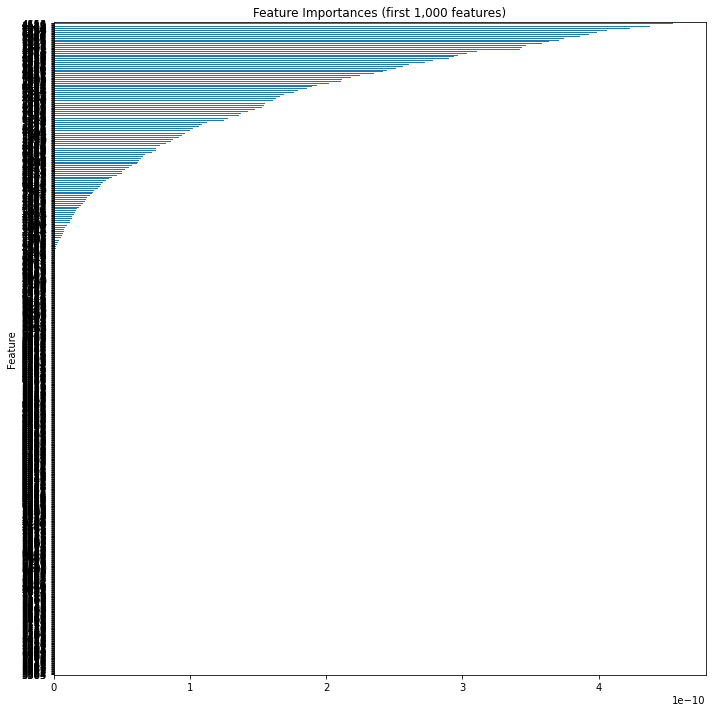

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot feature importances
rf_imps = pd.Series(model.named_steps['rf'].feature_importances_).sort_values()#index=X.columns.tolist()
# feature imp std dev
std_dev_imps = np.std([tree.feature_importances_ for tree in model.named_steps['rf'].estimators_], axis=0)
fig,ax = plt.subplots(figsize=(10,10))
rf_imps[:1000].plot.barh(ax=ax) # xerr=std_dev_imps[:1000]
ax.set_title("Feature Importances (first 1,000 features)")
ax.set_ylabel("Feature")
fig.tight_layout()

---

# rev 2 - fitting a model on each target instead of a meta model...

instead of fitting one multioutput random forest, lets fit a univariate random forest for each of our predictors

In [15]:
print(f'Our target variables, so the target of each of {len(targets)} models, are: {targets}')


Our target variables, so the target of each of 4 models, are: ['ChargeHours', 'ProductionRevActual', 'Cost', 'NumAssociatesOnJob']


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline
def wrapper_model(target,train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y):
    print(f'model for {target}')
    
    # fit the pipeline to train a logistic regression model on the training set
    model = pipeline.fit(train_X, train_y)
    #print (model)
    model.score(train_X,train_y)
    preds = model.predict(test_X)
   
    # Display metrics
    mse = mean_squared_error(test_y, preds)
    print("MSE:", mse)
    rmse = np.sqrt(mse)
    print("RMSE:", rmse)
    r2 = r2_score(test_y, preds)
    print("R2:", r2)

    fi = model.named_steps['rf'].feature_importances_
    print(f'Num Feature Importances: {len(fi)}')

    # plot feature importances
    rf_imps = pd.Series(model.named_steps['rf'].feature_importances_).sort_values()#index=X.columns.tolist()
    # feature imp std dev
    std_dev_imps = np.std([tree.feature_importances_ for tree in model.named_steps['rf'].estimators_], axis=0)
    fig,ax = plt.subplots(figsize=(10,6))
    rf_imps[:10].plot.barh(ax=ax)# yerr=std_dev_imps
    ax.set_title("Feature Importances for RI WORDS Weights and Keyword Aggregations")
    ax.set_ylabel("Feature")
    fig.tight_layout()
    return (model, rmse, r2)
    
np.random.seed(42)
fitted_models = []
for t in targets:
    # timing
    start = dt.datetime.now()
    print(f'started training for target {t} @ {start}')
    
    # filter df and then create X,y
    df = df[cats+hi_card_cats+ords+numerics+ordinals_custom+targets]
    X = df.loc[:,~df.columns.isin(targets)]
    y = np.asarray(df[t]).ravel()
    #print(y.shape)
    train_X,test_X,train_y,test_y=  train_test_split(X,y,random_state=42,test_size=0.2,)
    model,rmse,r2 = wrapper_model(target=t,train_X=train_X, train_y=train_y, test_X=test_X, test_y=test_y)
    fitted_models.append((t,model,rmse,r2))
    
    # timing
    end = dt.datetime.now()
    print(f'ended: {end}')
    print(f'elapsed time training for target {t}: {(end-start)}')